## Point generator

Generate points based on the labels (taken as an input from the GUI)
structure of the point:
    (t0, vel, flag (1=hyperbolic, 0=linear), label)

In [1]:
import random
import numpy as np
import matplotlib.pylab as plt
from scipy import signal
%matplotlib inline


def points_gen(nDA,nR,nCN,nMU=5):
    # The function generates random values of t0 - velocity pairs
    # based on number of requested waves:
    # nDA - number of direct waves (linear moveout, label 'D')
    # nR - number of reflections (hyperbolic moveout, label 'R')
    # nCN - number of coherent noise events (linear moveout, label 'N')
    # nMU - number of multiples (hyperbolic, label 'M')
    # outputs (nDA+nR+nCN) * (4) list
    # each point in the list has the following structure
    # [t0 (intercept time), velocity, flag(1=hyperbolic, 0=linear), label(see above))]
    
    
    # direct arrival
    direct = []
    for n in range(nDA):
        direct.append([random.uniform(0,.1),random.uniform(.5,1.5),0,'D'])
    
    reflected = []
    multiples = []
    for n in range(nR):
        reflection = [random.uniform(0,3),random.uniform(1.5,3.5),1,'R']
        reflected.append(reflection)
        for nmult in range(2,nMU):
            multiples.append([nmult * reflection[0], reflection[1],1,'M'])
        
    noise = []
    for n in range(nCN):
        noise.append([random.uniform(-3,3),random.uniform(-3,3),0,'N'])
        
    
#    for n in range(nMU):
#        noise.append([random.uniform(random.uniform(2,2),4),random.uniform(1.5,2.5),1,'M'])

    events = direct + reflected + noise + multiples
    return events

## Convert points to data

Based on a point label, convert the point to t(x) series

In [2]:
def t_linear(x, v, t):
    # return a linear event (direct or coherent noise)
    return t + x/v

def t_reflected(x,v,t):
    return np.sqrt(t**2 + x**2 / v**2)

def points_to_data(events, dx = 0.005, xmax = 2):
    x = np.arange(0, xmax + dx, dx)
    t=[]
    labels = []
    
    for i in events:
        if i[3] == 'D' or i[3] == 'N':
            t.append(t_linear(x, i[1], i[0]))
            labels.append(i[3])
        if i[3] == 'R' or i[3] == 'M':
            t.append(t_reflected(x,i[1],i[0]))
            labels.append(i[3])
            
    return t, labels, x

# Make the data look like seismic

Transform the t(x) data into 2D matrix and then convolve with Ricker wavelet

In [3]:
def conv_ricker(array):
    points = 100
    a = 4.0
    ricker = signal.ricker(points, a)
    return np.convolve(array,ricker,mode='same')

def data_to_seism(data, x):
    dataround = np.round(data,decimals=2)
    
    dt = 0.01
    tmax = 4
    t = np.arange(0,tmax + dt,dt)
    
    datamatrix = np.zeros((len(t),len(x)))

    for event in dataround:
        for n, i in enumerate(event):
            idx = np.where((t >= i - 0.0001) & (t <= i + .0001))
            if np.size(idx[0]) != 0:
                #print(idx[0],n)
                datamatrix[idx[0][0]][n] = 1

    data_ricker = np.apply_along_axis(conv_ricker, 0, datamatrix)
    
    
    return data_ricker

# Visualiation

If flag == 1, mark with colors.

In [11]:
def data_plot(data_ricker, events, labels, x, colors = 'no'):

    fig, ax = plt.subplots()
    ax.imshow(seism, cmap='gray', interpolation='bicubic', extent=[0,2,4,0]);
    
    plt.ylabel('Time, s')
    plt.xlabel('Offset, km')
    
    if colors == 'yes':
        
    # plot waves with colors
        for n, event  in enumerate(events):
            if labels[n] == 'D':
                ax.plot(x,event,'r')
            if labels[n] == 'N':
                ax.plot(x,event,'b')
            if labels[n] == 'R':
                ax.plot(x,event,'g')
            if labels[n] == 'M':
                ax.plot(x,event,'y')
    ax.set_xlim([0,2])
    ax.set_ylim([0,4])
    ax.invert_yaxis()
    ax.set_aspect(1)
    return ax

In [12]:
# Generate points
events=points_gen(2,2,2)

# Convert generated points to data (t(x))
data, labels, x = points_to_data(events)

# Convert data to seismic
seism = data_to_seism(data, x)

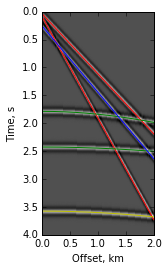

In [13]:
data_plot(seism,data,labels,x,'yes')

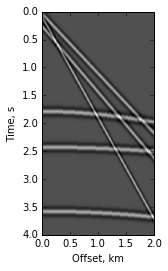

In [14]:
data_plot(seism,data,labels,x,'no')

In [70]:
# Convert data in list format to dictionary
    
def makeEventsDict(events):
    eventsDict = {}
    labelsDict = {}
    
    labelsDict['label'] = []
    eventsDict['direct'], eventsDict['reflected'], eventsDict['coherentnoise'], eventsDict['multiples'] = [],[],[],[]
    eventsDict['events'] = []
    for each in events:
#         print(each)
#         print(each[0])
#         print(each[3])
#         eventsDict['direct'].append(each[0])
#         eventsDict['reflected'].append(each[1])
#         eventsDict['coherentnoise'].append(each[2])
         eventsDict['events'].append(each[0:3])
         labelsDict['label'].append(each[3])
    return(eventsDict,labelsDict)

In [52]:
from sklearn import svm
SVC = svm.SVC()

# This function takes a events list, turns it into two dictionaries combined, splits that into two arrays for X and Y
# trains a SVM label on them and then returns that model output details
# The model will need to be run on a input for a prediction

def comboFunctionA(events):
    testEvents = makeEventsDict(events)
    eventsDict = testEvents[0]
    labelsDict = testEvents[1]
    X = eventsDict['events']
#     print("X = ",X)
    y = labelsDict['label']
#     print("y = ",y)
    clf = svm.SVC()
    output = clf.fit(X, y)
    return(output)

In [60]:
# training on a test set
events_train=points_gen(200,200,200,200)

tempAnswer = comboFunctionA(events_train)
tempAnswer

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [74]:
tempAnswer.predict([[.1,1.5,0]])

array(['D'], 
      dtype='<U1')